In [1]:
!git clone https://github.com/jeonsworld/ViT-pytorch.git

Cloning into 'ViT-pytorch'...


In [2]:
cd ViT-pytorch

C:\Users\Anuj\ViT-pytorch


C:\Users\Anuj\.conda\envs\FinalRK\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [12]:
!pip install -r requirements.txt
!pip install scikit-learn tqdm
!pip install vit_pytorch

Epoch [1/10] | Train Loss: 0.4583 | Train Acc: 80.74% | Val Loss: 0.2123 | Val Acc: 91.50%
Epoch [2/10] | Train Loss: 0.2197 | Train Acc: 88.93% | Val Loss: 0.4651 | Val Acc: 84.31%
Epoch [3/10] | Train Loss: 0.1823 | Train Acc: 92.62% | Val Loss: 0.2185 | Val Acc: 90.85%
Epoch [4/10] | Train Loss: 0.1506 | Train Acc: 92.21% | Val Loss: 0.1662 | Val Acc: 94.77%
Epoch [5/10] | Train Loss: 0.1431 | Train Acc: 95.90% | Val Loss: 0.2087 | Val Acc: 94.12%
Epoch [6/10] | Train Loss: 0.3962 | Train Acc: 84.84% | Val Loss: 0.3249 | Val Acc: 88.24%
Epoch [7/10] | Train Loss: 0.1325 | Train Acc: 96.72% | Val Loss: 0.2302 | Val Acc: 93.46%
Epoch [8/10] | Train Loss: 0.0741 | Train Acc: 96.72% | Val Loss: 0.2338 | Val Acc: 92.81%
Epoch [9/10] | Train Loss: 0.0249 | Train Acc: 99.59% | Val Loss: 0.2364 | Val Acc: 93.46%
Epoch [10/10] | Train Loss: 0.0347 | Train Acc: 98.36% | Val Loss: 0.2347 | Val Acc: 94.12%
✅ Training Complete! Best Validation Accuracy: 94.77%


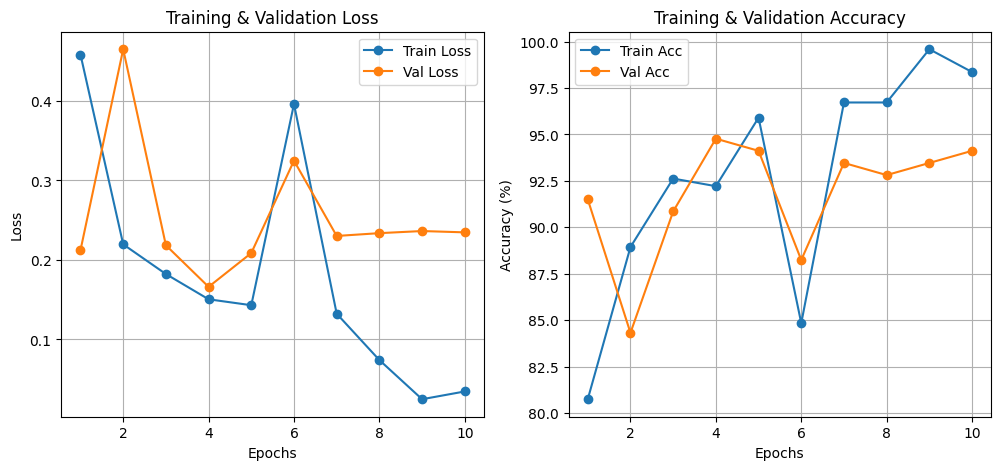

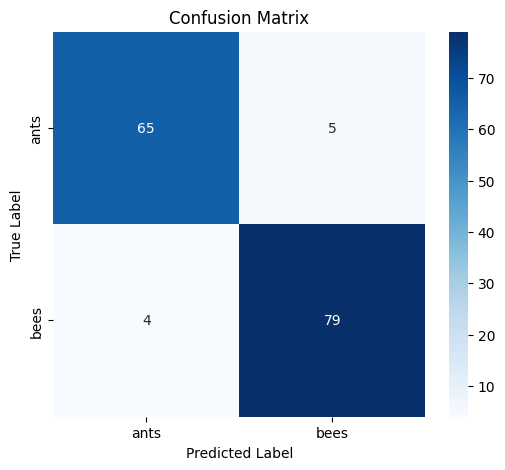

🔹 Classification Report:
              precision    recall  f1-score   support

        ants       0.94      0.93      0.94        70
        bees       0.94      0.95      0.95        83

    accuracy                           0.94       153
   macro avg       0.94      0.94      0.94       153
weighted avg       0.94      0.94      0.94       153



C:\Users\Anuj\AppData\Local\Temp\ipykernel_8608\1256615192.py:164: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_vit_model.pth"))


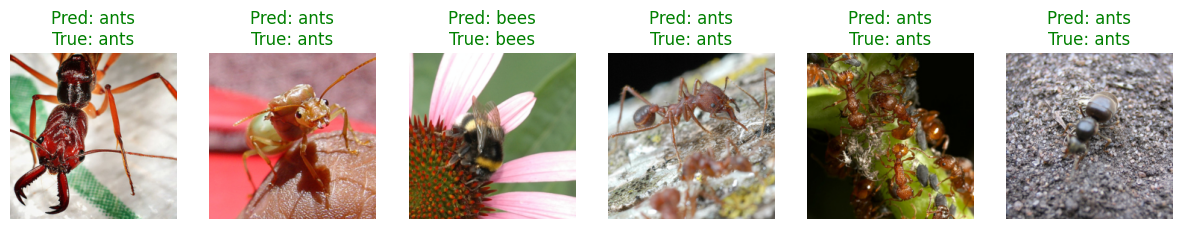

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import timm
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import random
from PIL import Image

# Data Preprocessing
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Replace with your dataset path
data_dir = r"C:\Users\Anuj\Favorites\Downloads\dataset\hymenoptera"
train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=data_transforms["train"])
val_dataset = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=data_transforms["val"])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

# Load Pretrained ViT Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=2)
model = model.to(device)

# Define Loss, Optimizer & Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1)


# Store loss & accuracy for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


# Training Loop
num_epochs = 10
best_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    train_loss, correct_train, total_train = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_acc = 100 * correct_train / total_train
    avg_train_loss = train_loss / len(train_loader)
    
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_acc = 100 * correct_val / total_val
    avg_val_loss = val_loss / len(val_loader)

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    scheduler.step(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_vit_model.pth")

print(f"Training Complete! Best Validation Accuracy: {best_acc:.2f}%")

# Plot Training & Validation Metrics
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, num_epochs + 1), val_losses, label="Val Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Acc", marker="o")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Val Acc", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid()

plt.show()

# Confusion Matrix & Classification Report
cm = confusion_matrix(all_labels, all_preds)
class_names = train_dataset.classes  # ['ants', 'bees']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report
print("🔹 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Load the Best Model & Show Predictions
model.load_state_dict(torch.load("best_vit_model.pth"))
model.eval()

def show_predictions(num_samples=6):
    model.eval()
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    sample_indices = random.sample(range(len(val_dataset)), num_samples)

    for i, idx in enumerate(sample_indices):
        image, label = val_dataset[idx]
        img_display = image.permute(1, 2, 0).numpy()
        img_display = img_display * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_display = np.clip(img_display, 0, 1)

        image = image.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(image)
            _, pred = torch.max(output, 1)

        axes[i].imshow(img_display)
        axes[i].axis("off")
        axes[i].set_title(f"Pred: {class_names[pred.item()]}\nTrue: {class_names[label]}",
                          color="green" if pred.item() == label else "red")

    plt.show()

# Call function to display results
show_predictions()
